# Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Esse foi meu primeiro projeto de processamento de linguagem natural na minha pós-graduação.

Nesse notebook foi realizada uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados como por exemplo o pyLDAvis e wordclouds. Como dataset foram utilizadas notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas:


1.   Download dos dados provenientes do kaggle 
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

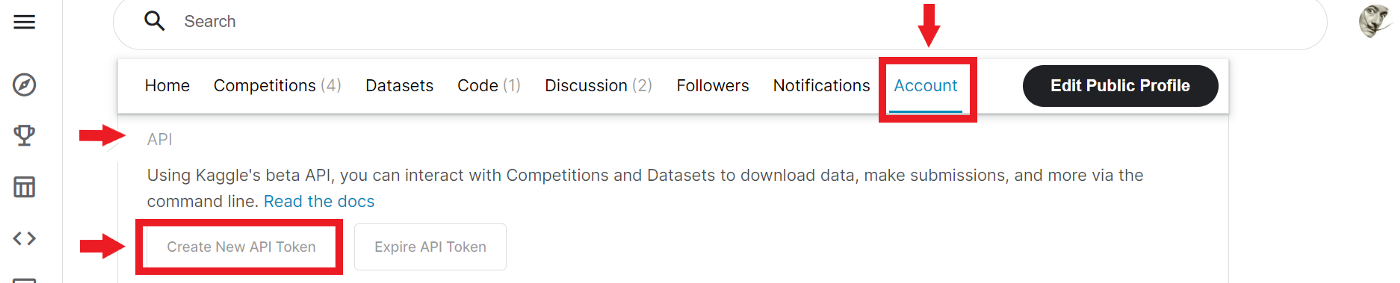

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json 

In [ ]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"higorsouzaeller","key":"4eee06ff05e2f12ea5a883c11ed17666"}'}

Crie a pasta .kaggle

In [ ]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Baixe o dataset

In [ ]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

 91% 171M/187M [00:01<00:00, 169MB/s]
100% 187M/187M [00:01<00:00, 145MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [ ]:
# Escreva seu código aqui
!pip install -U spacy > /dev/null
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.2 MB 6.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [ ]:
import nltk

nltk.download('punkt')
nltk.download("stopwords")
nltk.download("rslp")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [ ]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [ ]:
df['date'] = pd.to_datetime(df.date)
# Create a dataframe named news_2016
news_2016 = pd.DataFrame([{'title': title, 'text': text, 'date': date, 'category': category} for title, text, date, category in zip(df['title'], df['text'], df['date'], df['category']) if date.year == 2016 and category == 'mercado'])
# Optional data increase content, however there is a chance that topics will be more poorly distributed, since adding more information in theory makes it easier to promote a ranking
news_2016['more_information'] = news_2016['title'] + '. ' + news_2016['text']

## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem). 
Para tal, complete o conteúdo da função `tokenize`.

In [ ]:
def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`
  
  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  #escreva seu código aqui
  stopwords_pt = nltk.corpus.stopwords.words("portuguese")
  text = text.strip()
  tokens = nltk.word_tokenize(text, language='portuguese')
  words = [token for token in tokens if token.isalpha() not in stopwords_pt]
  st = nltk.stem.RSLPStemmer()
  stemmed_tokens = [st.stem(word) for word in words]
  return stemmed_tokens

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [ ]:
# Escreva seu código aqui
import pt_core_news_lg

nlp = pt_core_news_lg.load()

news_2016.loc[:, 'spacy_doc'] = news_2016.text.progress_map(nlp)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as 
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [ ]:
import re
import html

def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    # Escreva seu código aqui
    undesired_tokens = ["o", "em", "em o", "em a", "ano", "de o"]
    if w.text not in complete_stopwords and w.lemma_ not in undesired_tokens and w.text.isalpha():
      return True

def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """ 
    # Escreva seu cógigo aqui
    lemma_tokens = [token.lemma_ for token in doc if filter(token) == True]
    
    def optional_clean_text(tokens: List):
      # Aplica o lowercase
      tokens = [token.lower() for token in tokens]
      # Converte os escapes html em string
      tokens = [html.unescape(token) for token in tokens]
      # Remove tags como <tab>
      tokens = [re.sub(r'<[^<>]*>', ' ', token) for token in tokens]
      # Remove URL de remarcação [Algum texto](https://....)
      tokens = [re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', token) for token in tokens]
      # Texto ou código entre colchetes como [0]
      tokens = [re.sub(r'\[[^\[\]]*\]', ' ', token) for token in tokens]
      # Sequências de caracteres sozinhos, encontra &# mas não #cool
      tokens = [re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', token) for token in tokens]
      # Sequências de hífens sozinhos como --- or ==
      tokens = [re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', token) for token in tokens]
      # Sequências de espaços em branco
      tokens = [re.sub(r'\s+', ' ', token) for token in tokens]
      # Remove outros caracteres especiais se houver
      PATTERN = r'[?|-|º|!|$|&|*|%|@|(|)|~|.|"|,|;|:|+|=|_|/|\|]'
      tokens = [re.sub(PATTERN, r'', token) for token in tokens]
      tokens = [token.replace(" ", "") for token in tokens]
      tokens = [token.replace("''", "") for token in tokens]
      tokens = [token.replace("'", "") for token in tokens]
      tokens = [token.replace("`", "") for token in tokens]
      tokens = [token.replace("``", "") for token in tokens]
      # Remove os números que constam como string
      pattern = r'[0-9]'
      tokens = [re.sub(pattern, r'', token) for token in tokens]
      # Remove as strings vazias
      tokens = ' '.join(tokens).split()

      return tokens
    
    lemma_tokens = optional_clean_text(lemma_tokens)

    return lemma_tokens

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [ ]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  # Escreva seu código aqui
  orgs = []
  for ent in doc.ents:
      if ent.label_ != "ORG":
          continue
      orgs.append(ent.text)
  orgs = list(set(orgs))
  if len(orgs) > 1:
      orgs.append(orgs)
  
  return orgs


news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF. 
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos. 

In [ ]:
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None

  
  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      # Escreva seu código aqui
      def tokenizer(doc):
        return doc

      tfidf = TfidfVectorizer(tokenizer=tokenizer, lowercase=False, min_df=10, max_features=5000)
      tfidf.fit(self.doc_tokens)
      self.tfidf = tfidf
      return self.tfidf

  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [ ]:
#Escreva seu código aqui
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())

lda = LDA(n_components=N_TOKENS, max_iter=100, random_state=SEED).fit(corpus)

tfidf = TfidfVectorizer(tokenizer= lambda x: x, lowercase=False, stop_words=complete_stopwords, min_df=10, max_features=5000)
tfidf.fit(news_2016['spacy_lemma'])

### Visualize os tópicos usando a ferramenta pyLDAVis

In [ ]:
# Escreva seu código aqui
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

corpus_matrix = np.matrix(corpus)

pyLDAvis.sklearn.prepare(lda, corpus_matrix, tfidf)

### Atribua a cada text, um (e apenas um) tópic. 

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [ ]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    # Escreva seu código aqui
    lda_out = lda.transform([tfidf])
    topic = np.argmax(lda_out)

    return topic

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

  0%|          | 0/7943 [00:00<?, ?it/s]

## Número de documentos vs tópicos 

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

In [ ]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    # Escreva seu código aqui
    wordcloud = WordCloud(width=800, height=800, colormap="Oranges_r").generate(text)
    plt.figure()
    plt.axis("off")
    
    return ax.imshow(wordcloud, interpolation='bilinear')
    
def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(4, 2, figsize=(64, 60))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa. 

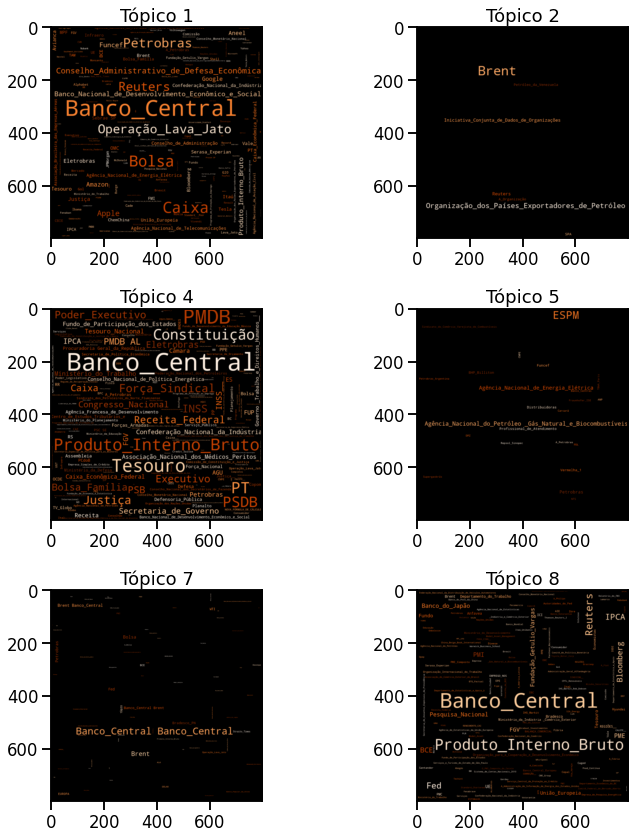

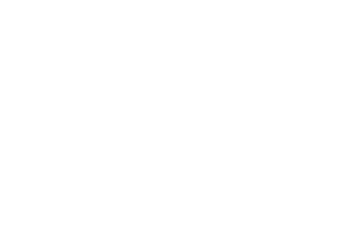

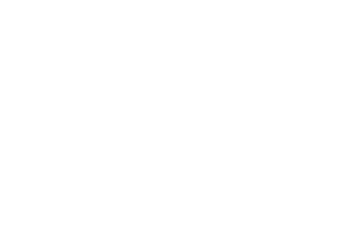

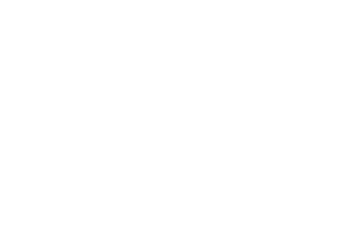

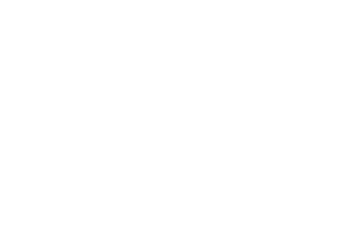

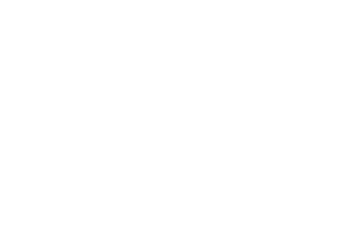

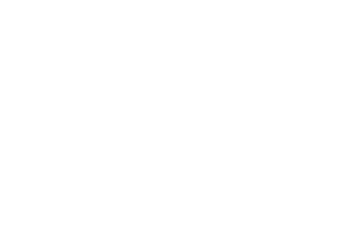

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w[0].replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()